# Generating synthetic data from the Altman Z-score model

The model is a well-known bankruptcy prediction approach, from the original paper by Ed Altman (1968). A brief summary is provided at the URL below (available on many other sites):

https://www.creditguru.com/index.php/bankruptcy-and-insolvency/altman-z-score-insolvency-predictor

The model uses 8 inputs converted into 5 financial ratios: 
1. Current assets
2. Current liabililties
3. Total Liabilities
4. EBIT
5. Total Assets
6. Net Sales
7. Retained earnings
8. Market value of equity

There are strict relationships between these 8 items and we model them as such. 

Ratios: 
- A: EBIT / Total Assets 
- B: Net Sales / Total Assets
- C: Mkt Value of equity / Total Liabilities
- D: Working Capital / Total Assets
- E: Retained Earnings / Total Assets

$$
Zscore = 3.3A + 0.99 B + 0.6 C + 1.2 D + 1.4 E
$$

Ranges
- $Z>3.0$: safe
- $2.7 < Z < 2.99$: caution
- $1.8 < Z < 2.7$: bankruptcy possible in 2 years
- $Z < 1.8$: high chance of bankruptcy

DATA 
- Balance sheet data: https://fred.stlouisfed.org/release/tables?rid=434&eid=196197
- Income statement data: https://fred.stlouisfed.org/release/tables?rid=434&eid=195208
- Price to book : http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/pbvdata.html

In [1]:
# Data for Q1 2021 (taken from the sources above)
CL = 2298532
TL = 6960819
EQ = 1512808
RE = 3390350
CA = 3148207
TA = 11863977
NS = 1659606
EBIT = 157123
P2B = 4.75
MVE = P2B*(EQ+RE)
WC = CA - CL

In [2]:
A = EBIT/TA
B = NS/TA
C = MVE/TL
D = WC/TA
E = RE/TA

In [3]:
Zscore = 3.3*A + 0.99*B + 0.6*C + 1.2*D + 1.4*E
print("Zscore for the average Mfg etc company =", Zscore)

Zscore for the average Mfg etc company = 2.6757314028323314


We normalize all the values above to having TA = 100

In [4]:
CL = CL/TA*100
TL = TL/TA*100
EQ = EQ/TA*100
RE = RE/TA*100
CA = CA/TA*100
NS = NS/TA*100
EBIT = EBIT/TA*100
MVE = P2B*(EQ+RE)
WC = CA - CL
print("CL =",CL," | TL =",TL," | EQ =",EQ," | RE =",RE," | CA =",CA," | NS =",NS,
      " | EBIT =",EBIT," | MVE =",MVE," | WC =",WC)

TA = 100
A = EBIT/TA
B = NS/TA
C = MVE/TL
D = WC/TA
E = RE/TA

Zscore = 3.3*A + 0.99*B + 0.6*C + 1.2*D + 1.4*E
print("[Check] Zscore for the average Mfg etc company =", Zscore)

CL = 19.37404295372454  | TL = 58.671885490000534  | EQ = 12.751272191441368  | RE = 28.576842318558104  | CA = 26.535848813597667  | NS = 13.988614441852004  | EBIT = 1.3243704029432963  | MVE = 196.3085439224975  | WC = 7.161805859873127
[Check] Zscore for the average Mfg etc company = 2.6757314028323314


## Use these baseline values to simluate Zscores

In [5]:
%pylab inline
import pandas as pd

def genFinancials(noise=0.10):
    ok = True
    total_assets = 100.0
    current_liabs = CL*(1+noise*(rand()-0.5))
    total_liabs = TL*(1+noise*(rand()-0.5))
    equity = EQ*(1+noise*(rand()-0.5))
    retained_earnings = RE*(1+noise*(rand()-0.5))
    current_assets = CA*(1+noise*(rand()-0.5))
    net_sales = NS*(1+noise*(rand()-0.5))
    ebit = EBIT*(1+noise*(rand()-0.5))
    price2book = P2B*(1+noise*(rand()-0.5))
    mve = price2book*(equity + retained_earnings)
    wc = current_assets - current_liabs
    if current_liabs > total_liabs:
        ok = False
    if equity + retained_earnings + total_liabs > total_assets:
        ok = False
    if current_assets > total_assets:
        ok = False
    if ebit > net_sales:
        ok = False
    if price2book < 0:
        ok = False
#     print("CL =",current_liabs," | TL =",total_liabs," | EQ =",equity,
#           " | RE =",retained_earnings," | CA =",current_assets," | NS =",net_sales,
#       " | EBIT =",ebit," | MVE =",mve," | WC =",wc)
    if ok==False:
        return [-999]*6
    else:
        A = ebit/total_assets
        B = net_sales/total_assets
        C = mve/total_liabs
        D = wc/total_assets
        E = retained_earnings/total_assets
        Zscore = 3.3*A + 0.99*B + 0.6*C + 1.2*D + 1.4*E
        Zscore = Zscore + randn()/2  # add some noise, default value=6
        return [Zscore, A, B, C, D, E, total_assets, current_liabs, total_liabs,
                retained_earnings, current_assets, net_sales, ebit, mve]

Populating the interactive namespace from numpy and matplotlib


## Read in the Text file and determine how many firms to generate data for

In [6]:
df_text = pd.read_csv('CCR_synthetic_text_nlp_scores.csv')
num_firms = len(df_text)
print("Number of firms =", num_firms)
df_text.columns

Number of firms = 3286


Index(['MDNA', 'industry_code', 'certainty', 'fraud', 'litigious', 'negative',
       'polarity', 'positive', 'readability', 'risk', 'safe', 'sentiment',
       'uncertainty'],
      dtype='object')

## Compute the zscores for an equal number of firms

CPU times: user 87.6 ms, sys: 824 µs, total: 88.4 ms
Wall time: 85.6 ms


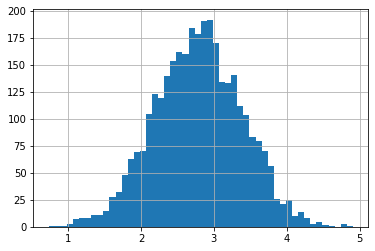

In [7]:
%%time
n = 0; z_list = []
rtable = zeros((num_firms, 14))
while n<num_firms:
    res = genFinancials(0.3)
    if res[0]>0:
        rtable[n,:] = res
        n = n + 1

z_list = rtable[:,0]
df_tabular = pd.DataFrame(rtable)
df_tabular.columns = ["Zscore","A","B","C","D","E",
                      "TotalAssets","CurrentLiabs","TotalLiabs",
                      "RetainedEarnings", "CurrentAssets", "NetSales", 
                      "EBIT", "MktValueEquity"]
hist(z_list,50); grid()

## Now assign ratings to each firm

http://pages.stern.nyu.edu/~ealtman/3-%20CopCrScoringModels.pdf

Two steps: 
1. Scale the Zscore to (0, 7) based on slide 9 in the URL above.
2. Assign ratings based on the bins in that same slide.

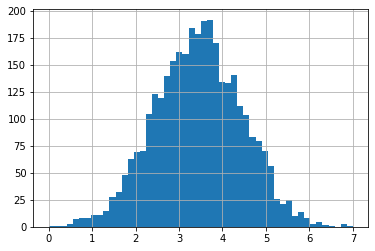

In [8]:
# Step 1
z_new = (z_list - min(z_list))/(max(z_list) - min(z_list)) 
z_new = z_new*7.0
hist(z_new, 50); grid()
df_tabular.Zscore = z_new

In [9]:
# Step 2
def z2rating(z):
    z = max(0, z-0.75) #artificially lower ratings to balance the sample
    if z > (6.20 + 4.73)/2:
        return "AAA"
    elif z > (4.73 + 3.74)/2:
        return "AA"
    elif z > (3.74 + 2.81)/2:
        return "A"
    elif z > (2.81 + 2.38)/2:
        return "BBB"
    elif z > (2.38 + 1.80)/2:
        return "BB"
    elif z > (1.80 + 0.33)/2:
        return "B"
    else:
        return "CCC"

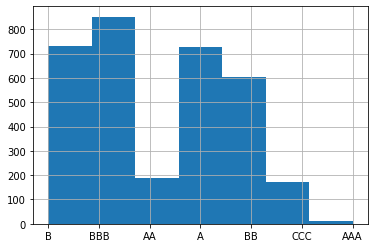

In [10]:
ratings = [z2rating(j) for j in z_new]
df_tabular["Rating"] = ratings
hist(ratings,7); grid()

In [11]:
print(df_tabular.groupby('Rating').mean())
print(df_tabular.groupby('Rating').count()['Zscore']/num_firms)

          Zscore         A         B         C         D         E  \
Rating                                                               
A       4.450039  0.013226  0.139313  3.815192  0.073038  0.290106   
AA      5.345878  0.013281  0.139996  4.006864  0.076979  0.293794   
AAA     6.520079  0.013241  0.142013  4.444512  0.073854  0.296874   
B       2.409842  0.013253  0.139443  3.291255  0.070629  0.270867   
BB      3.099130  0.013223  0.140043  3.444675  0.072499  0.275433   
BBB     3.671884  0.013221  0.139888  3.590184  0.072574  0.280385   
CCC     1.386431  0.013224  0.138728  3.072221  0.068605  0.263653   

        TotalAssets  CurrentLiabs  TotalLiabs  RetainedEarnings  \
Rating                                                            
A             100.0     19.297270   53.696487         29.010563   
AA            100.0     19.110854   53.189064         29.379443   
AAA           100.0     18.767973   51.161779         29.687358   
B             100.0     19.467320 

In [12]:
df_tabular.head()

,Zscore,A,B,C,D,E,TotalAssets,CurrentLiabs,TotalLiabs,RetainedEarnings,CurrentAssets,NetSales,EBIT,MktValueEquity,Rating
0,2.046582,0.011330,0.127826,3.633782,0.074792,0.250559,100.0,21.717719,55.907542,25.055914,29.196927,12.782556,1.132961,203.155819,B
1,3.729820,0.015079,0.160580,3.356486,0.050406,0.281856,100.0,22.233085,55.959605,28.185615,27.273732,16.058042,1.507895,187.827630,BBB
2,2.456736,0.012869,0.139153,3.058346,0.086300,0.278852,100.0,21.694070,56.566388,27.885221,30.324085,13.915275,1.286886,172.999608,B
3,3.590760,0.014874,0.121708,3.303709,0.105255,0.252464,100.0,19.313079,50.979594,25.246448,29.838582,12.170814,1.487379,168.421762,BBB
4,3.629748,0.013386,0.122018,3.781580,0.017301,0.300067,100.0,22.037749,53.056126,30.006743,23.767882,12.201751,1.338605,200.635963,BBB


## Attach Ratings and Ratios to the Text 

In [13]:
df_text.negative = df_text.negative*(-1)
df_text.head()

,MDNA,industry_code,certainty,fraud,litigious,negative,polarity,positive,readability,risk,safe,sentiment,uncertainty
0,MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINAN...,H,0.037973,0.024456,0.022701,0.024456,0.508808,0.075121,3846.808333,0.036735,0.037251,0.081,0.018471
1,Management's Discussion and Analysis of Finan...,D,0.041008,0.034980,0.029592,0.028404,0.493073,0.083661,4338.103271,0.047036,0.057174,0.051,0.019910
2,Management's Discussion and Analysis of Fina...,H,0.033996,0.040126,0.037526,0.028516,0.531298,0.093164,4242.693973,0.041612,0.064555,0.070,0.022292
3,"""Management's Discussion and Analysis of Fina...",D,0.035461,0.051221,0.052797,0.052797,0.234286,0.085106,516.687747,0.095351,0.060678,0.010,0.041765
4,Management’s Discussion and Analysis of Finan...,D,0.039932,0.033259,0.027857,0.030505,0.523179,0.097447,3746.336252,0.043639,0.067366,0.079,0.026586


In [14]:
df_text.corr()

,certainty,fraud,litigious,negative,polarity,positive,readability,risk,safe,sentiment,uncertainty
certainty,1.000000,0.284842,0.155795,0.104988,0.105286,0.350232,0.324095,0.271133,0.171510,0.094256,0.267970
fraud,0.284842,1.000000,0.590540,0.233644,-0.120129,0.139484,0.015395,0.318075,0.376067,-0.038576,0.219067
litigious,0.155795,0.590540,1.000000,0.309533,-0.157785,0.190960,0.105918,0.294686,0.505904,0.007045,0.230790
negative,0.104988,0.233644,0.309533,1.000000,-0.836728,0.089196,0.127334,0.720108,0.059142,-0.328005,0.533996
polarity,0.105286,-0.120129,-0.157785,-0.836728,1.000000,0.460712,-0.080127,-0.558475,0.206956,0.387387,-0.336405
positive,0.350232,0.139484,0.190960,0.089196,0.460712,1.000000,0.050056,0.136524,0.459604,0.193497,0.242750
readability,0.324095,0.015395,0.105918,0.127334,-0.080127,0.050056,1.000000,0.205652,0.078483,0.000424,0.292217
risk,0.271133,0.318075,0.294686,0.720108,-0.558475,0.136524,0.205652,1.000000,0.059156,-0.382823,0.426502
safe,0.171510,0.376067,0.505904,0.059142,0.206956,0.459604,0.078483,0.059156,1.000000,0.321970,0.155936
sentiment,0.094256,-0.038576,0.007045,-0.328005,0.387387,0.193497,0.000424,-0.382823,0.321970,1.000000,-0.126917


In [15]:
df_text['rank'] = (df_text.positive + df_text.polarity + df_text.safe + \
                   df_text.sentiment + df_text.certainty) - \
                    (df_text.fraud + df_text.litigious + df_text.negative + \
                     df_text.uncertainty + df_text.risk)

In [16]:
df_rating_count = df_tabular.groupby('Rating').Zscore.count()
df_rating_count

Rating
A      729
AA     187
AAA     10
B      730
BB     605
BBB    852
CCC    173
Name: Zscore, dtype: int64

In [17]:
df_ccr = df_text.sort_values(by = ['rank'], ascending=False)
df_ccr = df_ccr.reset_index(drop=True)
df_ccr.head()

,MDNA,industry_code,certainty,fraud,litigious,negative,polarity,positive,readability,risk,safe,sentiment,uncertainty,rank
0,Management's Discussion and Analysis of Finan...,D,0.010210,0.017584,0.015598,0.018151,0.718062,0.110607,1409.333827,0.025808,0.060408,0.135,0.011628,0.945518
1,Management's Discussion and Analysis of Finan...,D,0.010127,0.018229,0.019097,0.018229,0.705607,0.105613,1378.839382,0.028067,0.054688,0.106,0.009838,0.888575
2,Management's Discussion and Analysis of Finan...,D,0.012941,0.016520,0.016795,0.020099,0.696466,0.112335,1452.019469,0.031663,0.053965,0.108,0.011289,0.887340
3,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,I,0.042945,0.023067,0.021759,0.022658,0.631894,0.100450,4830.242416,0.042699,0.068548,0.165,0.020286,0.878366
4,Management's Discussion and Analysis of Finan...,D,0.012471,0.019226,0.017667,0.022863,0.656920,0.110418,1538.226155,0.032476,0.063913,0.137,0.010133,0.878358


In [18]:
df_ccr = df_ccr[['MDNA','industry_code']]

In [19]:
df = df_tabular.sort_values(by = ['Zscore'], ascending=False)
df = df.reset_index(drop=True)
df.head()

,Zscore,A,B,C,D,E,TotalAssets,CurrentLiabs,TotalLiabs,RetainedEarnings,CurrentAssets,NetSales,EBIT,MktValueEquity,Rating
0,7.000000,0.013349,0.147749,4.724044,0.040030,0.325473,100.0,20.868258,50.501544,32.547303,24.871286,14.774910,1.334931,238.571513,AAA
1,6.807812,0.011371,0.124473,4.277806,0.094806,0.287603,100.0,19.622967,50.352084,28.760326,29.103598,12.447340,1.137064,215.396468,AAA
2,6.760984,0.013901,0.130745,4.220950,0.030868,0.299036,100.0,21.474133,55.007104,29.903571,24.560932,13.074464,1.390076,232.182228,AAA
3,6.751019,0.012036,0.157651,4.554120,0.059351,0.297489,100.0,20.135293,50.225308,29.748943,26.070400,15.765115,1.203600,228.732074,AAA
4,6.519366,0.011898,0.126121,4.749226,0.067430,0.294803,100.0,17.417811,49.893589,29.480277,24.160795,12.612130,1.189818,236.955918,AAA


In [20]:
# df = df_tabular[df_tabular.Rating=="AAA"]
# for r in ["AA","A","BBB","BB","B","CCC"]:
#     df1 = df_tabular[df_tabular.Rating==r]
#     df = pd.concat([df,df1])

In [21]:
df = df[["A","B","C","D","E","TotalAssets","CurrentLiabs","TotalLiabs",
                      "RetainedEarnings", "CurrentAssets", "NetSales", 
                      "EBIT", "MktValueEquity","Rating"]]
df_ccr = pd.concat([df_ccr,df], axis=1)
df_ccr

,MDNA,industry_code,A,B,C,D,E,TotalAssets,CurrentLiabs,TotalLiabs,RetainedEarnings,CurrentAssets,NetSales,EBIT,MktValueEquity,Rating
0,Management's Discussion and Analysis of Finan...,D,0.013349,0.147749,4.724044,0.040030,0.325473,100.0,20.868258,50.501544,32.547303,24.871286,14.774910,1.334931,238.571513,AAA
1,Management's Discussion and Analysis of Finan...,D,0.011371,0.124473,4.277806,0.094806,0.287603,100.0,19.622967,50.352084,28.760326,29.103598,12.447340,1.137064,215.396468,AAA
2,Management's Discussion and Analysis of Finan...,D,0.013901,0.130745,4.220950,0.030868,0.299036,100.0,21.474133,55.007104,29.903571,24.560932,13.074464,1.390076,232.182228,AAA
3,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,I,0.012036,0.157651,4.554120,0.059351,0.297489,100.0,20.135293,50.225308,29.748943,26.070400,15.765115,1.203600,228.732074,AAA
4,Management's Discussion and Analysis of Finan...,D,0.011898,0.126121,4.749226,0.067430,0.294803,100.0,17.417811,49.893589,29.480277,24.160795,12.612130,1.189818,236.955918,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,"of this report. Regulatory, Legislative, and L...",H,0.012455,0.152003,3.483915,0.064590,0.254946,100.0,17.853466,58.028358,25.494603,24.312514,15.200251,1.245472,202.165890,CCC
3282,"of this report. Regulatory, Legislative, and L...",H,0.015026,0.122810,2.731078,0.071193,0.258524,100.0,18.625728,60.543515,25.852383,25.745013,12.280980,1.502558,165.349046,CCC
3283,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,D,0.014954,0.153887,2.818871,0.077557,0.282100,100.0,22.220044,59.374450,28.210000,29.975709,15.388667,1.495376,167.368922,CCC
3284,MANAGEMENT’S DISCUSSION AND ANALYSIS OF FINAN...,D,0.012874,0.121627,3.027952,0.097372,0.252077,100.0,17.237602,56.490629,25.207663,26.974804,12.162667,1.287359,171.050929,CCC


## Save the multimodal dataset

In [22]:
df_ccr.to_csv("CCR_data_full.csv", index=False)

In [23]:
df_final = df_ccr.drop(["A","B","C","D","E"], axis=1)
df_final.to_csv("CCR_data.csv", index=False)

In [24]:
df_final.columns

Index(['MDNA', 'industry_code', 'TotalAssets', 'CurrentLiabs', 'TotalLiabs',
       'RetainedEarnings', 'CurrentAssets', 'NetSales', 'EBIT',
       'MktValueEquity', 'Rating'],
      dtype='object')